In [15]:
import AFQ.data as afqd
import AFQ.viz.utils as plot_utils
import afqinsight as afqi
import json
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from matplotlib.gridspec import  GridSpec
from matplotlib.legend_handler import HandlerTuple
from plot_formatting import set_size
from plot_utils import plot_coefs_on_bundle_cores
from sklearn.metrics import accuracy_score, r2_score, median_absolute_error, roc_auc_score
from string import Template
from textwrap import wrap
from tqdm.auto import tqdm

from neurocombat_sklearn import CombatModel
from groupyr.transform import GroupExtractor, GroupRemover
from sklearn.impute import SimpleImputer

plt.style.use('tex')
fig_dir = "../reports/paper_figures"
latex_output_file = "../reports/manuscript/output.tex"

COLUMN_WIDTH = 246.0  # in points
FULL_TEXT_WIDTH = 510.0  # in points
FULL_TEXT_LENGTH = 660.0  # in points

In [3]:
with open("hbn_regression_paper.pkl", "rb") as fp:
    hbn_results = pickle.load(fp)

# HBN age regression

In [4]:
hbn_bagging_results = hbn_results["bagging_target_transform"][0]

X, y, groups, columns, group_names, subjects, classes = afqi.load_afq_data(
    "../data/raw/hbn_data",
    target_cols=["Age"],
    index_col="EID"
)

df_y = pd.read_csv("../data/raw/hbn_data/9994_Basic_Demos_20210329.csv").drop(axis="rows", index=0)
df_y = df_y[["EID", "Age"]]
df_y = df_y.set_index("EID", drop=True)

df_subs = pd.DataFrame(index=subjects).merge(df_y, how="left", left_index=True, right_index=True)
df_subs = df_subs[~df_subs.index.duplicated(keep="first")]
print(df_subs.shape)

y = df_subs["Age"].astype(np.float64).to_numpy()
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]
subjects = list(np.array(subjects)[nan_mask])

print(X.shape)
print(y.shape)
print(len(subjects))

(2085, 1)
(1999, 3600)
(1999,)
1999


In [13]:
df_sites = pd.read_csv(
    "../data/raw/hbn_data/combined_tract_profiles-20210128.csv", usecols=["subjectID", "sessionID"]
).drop_duplicates().set_index("subjectID")

df_sites = pd.DataFrame(index=subjects).merge(
    df_sites, how="left", left_index=True, right_index=True
)

site_mask = np.logical_and(
    df_sites["sessionID"] != "HBNsiteSI",
    df_sites["sessionID"] != "HBNsiteCUNY"
).to_numpy()

df_sites = df_sites[site_mask]
X = X[site_mask]
y = y[site_mask]
subjects = list(np.array(subjects)[site_mask])

df_sites["site_idx"] = df_sites["sessionID"].map({"HBNsiteRU": 0, "HBNsiteCBIC": 1})
df_sites["site_id"] = df_sites["sessionID"].map({"HBNsiteRU": "RU", "HBNsiteCBIC": "CBIC"})
sites = df_sites["site_idx"].to_numpy()

print(X.shape)
print(y.shape)
print(len(subjects))
print(sites.shape)
print(df_sites.isna().sum())

(1651, 3600)
(1651,)
1651
(1651,)
sessionID    0
site_idx     0
site_id      0
dtype: int64


In [10]:
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

X_site_harmonized = CombatModel().fit_transform(
    X_imputed,
    df_sites[["site_idx"]],
    None,
    None,
)

In [11]:
def plot_tract_profiles(
    X, groups, group_names, group_by, group_by_name=None,
    bins=None, quantiles=None, cmap_seq="crest", n_boot=500
):
    if bins is not None and quantiles is not None:
        raise ValueError("You specified both bins and quantiles. These parameters are mutually exclusive.")
    
    if (bins is not None or quantiles is not None) and group_by_name is None:
        raise ValueError("You must supply a group_by_name when binning using either the bins or quantiles parameter.")
        
    figs = {}
    
    metrics = np.unique([grp[0] for grp in group_names])
    tract_names = np.unique([grp[1] for grp in group_names])
    
    if len(group_by.shape) == 1:
        group_by = np.copy(group_by)[:, np.newaxis]
    
    groups_metric = [grp for gn, grp in zip(group_names, groups) if metrics[0] in gn]
    
    for metric in tqdm(metrics):
        X_metric = GroupExtractor(select=metric, groups=groups, group_names=group_names).fit_transform(X)
        group_names_metric = [gn for gn in group_names if metric in gn]
        
        # Create a dataframe for each bundle
        tract_stats = {}
        for tid in tract_names:
            X_select = GroupExtractor(select=tid, groups=groups_metric, group_names=group_names_metric).fit_transform(X_metric)
            columns = [idx for idx in range(X_select.shape[1])]
            df = pd.concat([
                pd.DataFrame(X_select, columns=columns, dtype=np.float64),
                pd.DataFrame(group_by, columns=["group_by"]),
            ], axis="columns")
            id_vars = ["group_by"]
            hue = "group_by"  # used later in seaborn functions
            
            if quantiles is not None:
                df["quantile"], bins = pd.qcut(df["group_by"].astype(np.float64), quantiles, retbins=True)
                hue = "quantile"
                id_vars.append("quantile")
                
            if bins is not None:
                df["bin"], bins = pd.cut(df["group_by"].astype(np.float64), bins, retbins=True)
                hue = "bin"
                id_vars.append("bin")
            
            df = df.melt(id_vars=id_vars, var_name="nodeID", value_name=metric)
            df["nodeID"] = df["nodeID"].astype(int)
            tract_stats[tid] = df
            
        # Arrange the bundles into a grid
        bgcolor = "white"
        positions = plot_utils.POSITIONS.copy()
        positions["FA"] = (0, 0)
        positions["FP"] = (0, 3)
        for bid in positions.keys():
            if bid.endswith("_R"):
                old_position = positions[bid]
                positions[bid] = (old_position[0], old_position[1] - 1)

        # Create the subplots
        fig, axes = plt.subplots(
            nrows=5, ncols=4,
            figsize=set_size(width=FULL_TEXT_LENGTH, subplots=(5, 4)),
            sharex=True
        )

        for tid, df_stat in tqdm(tract_stats.items()):
            bundle_id = afqd.BUNDLE_MAT_2_PYTHON.get(tid, tid)
            
            if "HCC_" in bundle_id or "Cingulum Hippocampus" in tid:
                continue
            
            ax = axes[positions[bundle_id][0],
                      positions[bundle_id][1]]
            
            if metric == "dki_md":
                df_stat[metric] *= 1000.0

            _ = sns.lineplot(
                x="nodeID", y=metric, hue=hue,
                data=df_stat,
                ci=68.2, palette=cmap_seq,
                ax=ax,
                linewidth=1.0,
                n_boot=n_boot
            )

            if positions[bundle_id][0] == 4:
                _ = ax.set_xlabel("% distance along fiber bundle")

            if (positions[bundle_id][1] == 0
                or (positions[bundle_id][1] == 1 and positions[bundle_id][0] == 4)):
                if metric in ["md", "dki_md"]:
                    _ = ax.set_ylabel(
                        r"{} $\left[ \mu \textrm{{m}}^2 / \textrm{{ms}} \right]$".format(
                            metric.lower().replace("_", " ")
                        )
                    )
                else:
                    _ = ax.set_ylabel(metric.lower().replace("_", " "))
            else:
                _ = ax.set(ylabel=None)

            _ = ax.tick_params(axis='both', which='major')
            _ = ax.set_facecolor(bgcolor)
            _ = ax.get_legend().remove()
                                
            _ = ax.set_title(bundle_id.replace("_", "").replace("FA", "CFA").replace("FP", "CFP"))

        _ = axes[4, 0].axis("off")
        _ = axes[4, 3].axis("off")
        
        handles, labels = ax.get_legend_handles_labels()
        
        if quantiles is not None or bins is not None:
            labels = [f"{group_by_name} {b[0]:.2f}-{b[1]:.2f}" for b in zip(bins[:-1], bins[1:])]
            
        leg = plt.figlegend(
            handles, labels,
            facecolor="whitesmoke",
            bbox_to_anchor=(0.5, 0.02),
            loc="upper center",
            ncol=6
        )

        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            _ = legobj.set_linewidth(3.0)

        fig.tight_layout(h_pad=0.5, w_pad=-0.5)

        figs[metric] = fig
        
    return figs

In [34]:
df_demo.head()

,Age,sessionID,site_idx,site_id
NDARAA306NT2,21.216746,HBNsiteRU,0,RU
NDARAA947ZG5,13.627880,HBNsiteCBIC,1,CBIC
NDARAA948VFH,7.982660,HBNsiteRU,0,RU
NDARAB055BPR,10.793862,HBNsiteRU,0,RU
NDARAB348EWR,5.805384,HBNsiteCBIC,1,CBIC


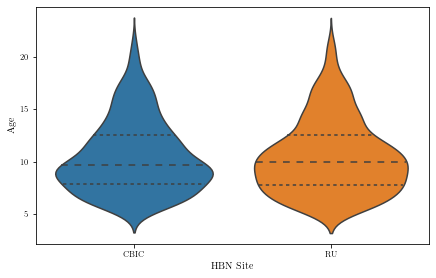

In [45]:
df_demo = df_subs.merge(df_sites, how="right", left_index=True, right_index=True)
df_demo["Age"] = df_demo["Age"].astype(np.float64)
fig, ax = plt.subplots(1, 1, figsize=set_size(width=FULL_TEXT_WIDTH))
_ = sns.violinplot(
    data=df_demo, x="site_id", y="Age", split=True,
    order=["CBIC", "RU"], scale="count", inner="quartile",
    ax=ax
)
ax.set_xlabel("HBN Site")

fig.savefig(op.join(fig_dir, "hbn_site_age_distributions.pdf"), bbox_inches="tight")

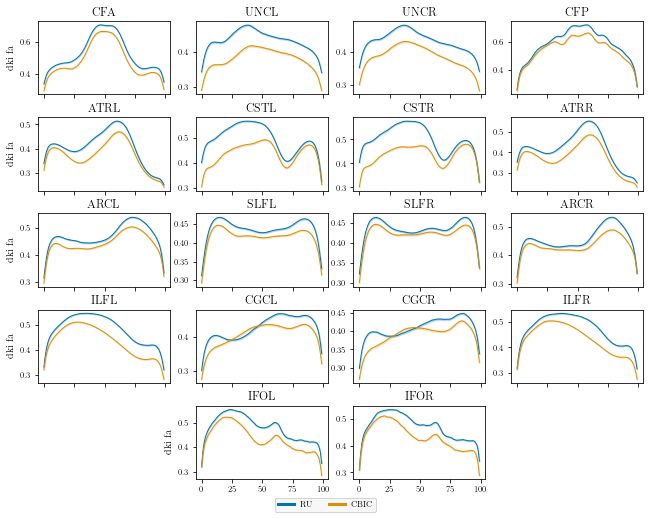

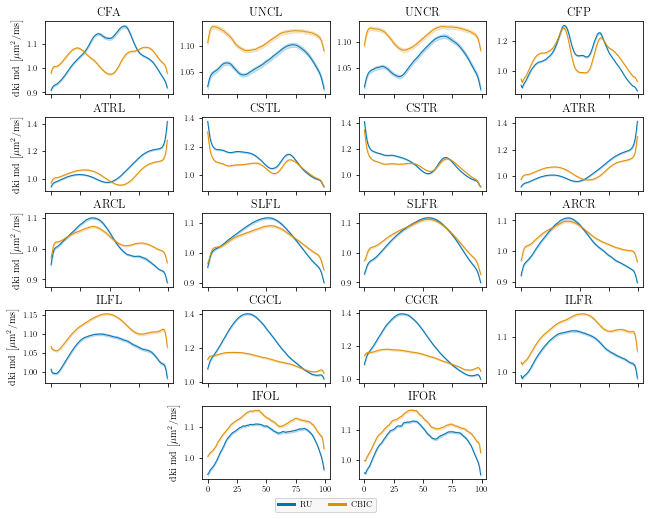

In [16]:
ba_sites = plot_tract_profiles(
    X=X_imputed,
    groups=groups,
    group_names=group_names,
    group_by=df_sites["site_id"].to_numpy(),
    cmap_seq="colorblind"
)

ba_sites["dki_fa"].savefig(op.join(fig_dir, "hbn_site_profiles_fa.pdf"), bbox_inches="tight")
ba_sites["dki_md"].savefig(op.join(fig_dir, "hbn_site_profiles_md.pdf"), bbox_inches="tight")

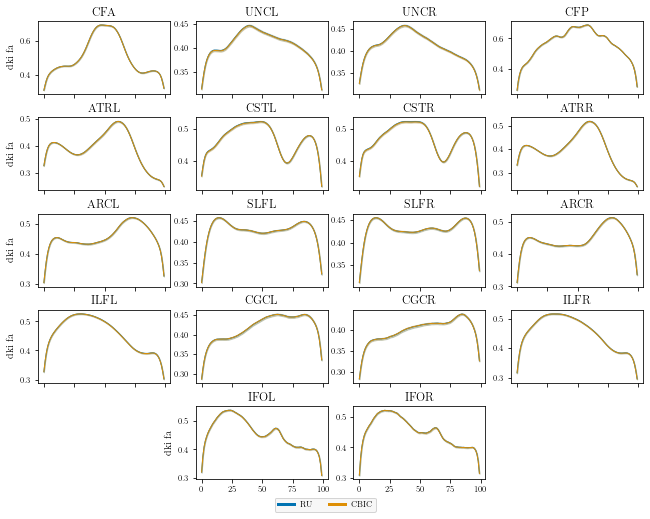

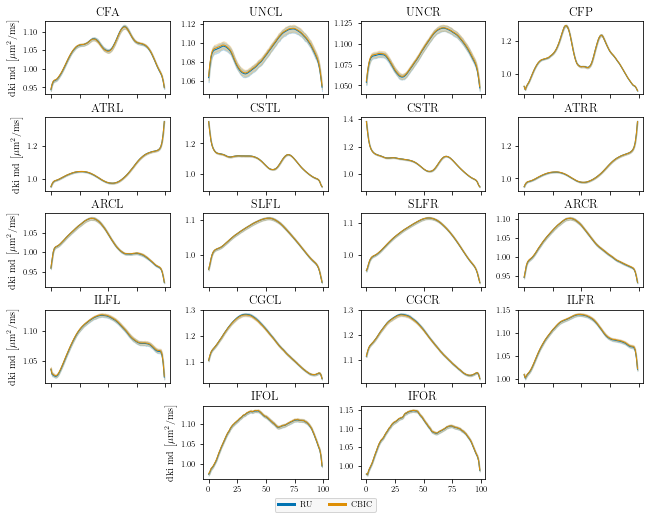

In [18]:
ba_sites = plot_tract_profiles(
    X=X_site_harmonized,
    groups=groups,
    group_names=group_names,
    group_by=df_sites["site_id"].to_numpy(),
    cmap_seq="colorblind"
)

ba_sites["dki_fa"].savefig(op.join(fig_dir, "hbn_harmonized_profiles_fa.pdf"), bbox_inches="tight")
ba_sites["dki_md"].savefig(op.join(fig_dir, "hbn_harmonized_profiles_md.pdf"), bbox_inches="tight")